In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

from slams.mcs import *
from slams.nn import *
from slams.score import *
from slams.utils import *

import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
import pandas as pd

### Sanity check: encoder-decoder

In [3]:
# Load testing data
size = (120, 240)
test_years = np.arange(2021, 2023)

/burg/home/jn2808/.conda/envs/bench/lib/python3.9/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.30.0
  warnings.warn(


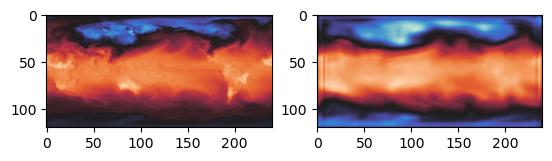

In [4]:
# Load model
latent = load_model_from_checkpoint(model_name='convae_0', version_num=0, from_root=False)

# Qualitative sanity check
test_idx, param_idx = 0, 9

# True
testset = ERA5Dataset(years=test_years, size=size, window=1, flatten=False)
x_true, _ = testset[test_idx]

# Preds
z = latent.model.encoder(x_true.to(device))
x_ = latent.model.decoder(z)
x_pred = x_.detach().cpu()

# Plot
f, ax = plt.subplots(1,2)
ax[0].imshow(x_true[0, param_idx], cmap=sns.cm.icefire) # True
ax[1].imshow(x_pred[0, param_idx], cmap=sns.cm.icefire) # Predicted

### Evaluation

In [5]:
# Load SDA model
sda = load_model_from_checkpoint(model_name='lsda_0', version_num=0, from_root=False)

Generate low frequency observations for assimilation (in latent space)

In [6]:
def coarsen(x: Tensor, r: int = 2) -> Tensor:
    *batch, h, w = x.shape

    x = x.reshape(*batch, h // r, r, w // r, r)
    x = x.mean(dim=(-3, -1))

    return x

def upsample(x: Tensor, r: int = 2, mode: str = 'bilinear') -> Tensor:
    *batch, h, w = x.shape

    x = x.reshape(-1, 1, h, w)
    x = torch.nn.functional.pad(x, pad=(1, 1, 1, 1), mode='circular')
    x = torch.nn.functional.interpolate(x, scale_factor=(r, r), mode=mode)
    x = x[..., r:-r, r:-r]
    x = x.reshape(*batch, r * h, r * w)

    return x

In [7]:
# Process label data
testset = ERA5Dataset(years=test_years, size=size, window=64, flatten=False)

test_x, _ = testset[0]
true_x = test_x[:29]
true_z = latent.model.encoder(true_x.to(device)).cpu()

In [8]:
# Varying resolution
coarsening_factors = [4, 8, 12, 15, 20]
n_corrections = 1
n_steps = 512
tau = 0.5
sigma_sq = 0.1
input_size = sda.hparams.model_args['input_size']
model_name = sda.hparams.model_args['model_name']

distances = dict()

for coarsening_f in coarsening_factors:
    
    # Process coarsen data
    def A(x):
        return coarsen(x[..., ::4, :, :, :], coarsening_f)

    y_star = torch.normal(A(true_x), sigma_sq)
    yz_star = torch.normal(A(true_z), sigma_sq)

    # For plotting
    w_true = true_x[::4]
    w_coarse = upsample(y_star, 2, mode='nearest')
    
    all_x_sample = []

    # Sampling for diffusion model
    lsde_eval = VPSDE(
        GaussianScore(
            y=yz_star,
            A=A,
            std=sigma_sq,
            sde=VPSDE(sda.score, shape=()),
        ),
        shape=true_z.shape).to(device)

    x = lsde_eval.sample(steps=n_steps, corrections=n_corrections, tau=tau)
    x = latent.model.decoder(x)
    x = x[::4]
    all_x_sample.append(x)

    # Combine all samples
    all_x_sample = torch.stack(all_x_sample)
    
    # Save plots and results
    docs_dir = Path(f'../docs/{model_name}')
    
    visual_dir = docs_dir / 'visual'
    dist_dir = docs_dir / 'dist'
    visual_dir.mkdir(parents=True, exist_ok=True)
    dist_dir.mkdir(parents=True, exist_ok=True)
    
    for param_idx in range(input_size):
        plot_assimilation_results(
            w_true, 
            w_coarse, 
            all_x_sample, 
            param_idx=param_idx, 
            save_file=docs_dir / 'visual' / f'coarse={coarsening_f}_param={param_idx}.pdf')

        wasserstein_d = plot_and_compute_distributions(
            w_true, 
            all_x_sample, 
            param_idx=param_idx, 
            save_file=docs_dir / 'dist' / f'coarse={coarsening_f}_param={param_idx}.pdf')
        
        try:
            distances[f'{param_idx}'].append(wasserstein_d)
            
        except:
            distances[f'{param_idx}'] = [wasserstein_d]

# Save metrics
df = pd.DataFrame.from_dict(distances, orient='index', columns=coarsening_factors)
df.to_csv(docs_dir / f'wasserstein_coarse.csv', index=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [18:01<00:00,  2.11s/it]


In [9]:
# Varying noise
sigma_sqs = [0.5, 1.0, 2.0, 4.0]
coarsening_f = 4
n_corrections = 1
n_steps = 512
tau = 0.5
input_size = sda.hparams.model_args['input_size']
model_name = sda.hparams.model_args['model_name']

distances = dict()

for sigma_sq in sigma_sqs:
    
    # Process coarsen data
    def A(x):
        return coarsen(x[..., ::4, :, :, :], coarsening_f)

    y_star = torch.normal(A(true_x), sigma_sq)
    yz_star = torch.normal(A(true_z), sigma_sq)

    # For plotting
    w_true = true_x[::4]
    w_coarse = upsample(y_star, 2, mode='nearest')
    
    all_x_sample = []

    # Sampling for diffusion model
    lsde_eval = VPSDE(
        GaussianScore(
            y=yz_star,
            A=A,
            std=sigma_sq,
            sde=VPSDE(sda.score, shape=()),
        ),
        shape=true_z.shape).to(device)

    x = lsde_eval.sample(steps=n_steps, corrections=n_corrections, tau=tau)
    x = latent.model.decoder(x)
    x = x[::4]
    all_x_sample.append(x)

    # Combine all samples
    all_x_sample = torch.stack(all_x_sample)
    
    # Save plots and results
    docs_dir = Path(f'../docs/{model_name}')
    
    visual_dir = docs_dir / 'visual'
    dist_dir = docs_dir / 'dist'
    visual_dir.mkdir(parents=True, exist_ok=True)
    dist_dir.mkdir(parents=True, exist_ok=True)
    
    for param_idx in range(input_size):
        plot_assimilation_results(
            w_true, 
            w_coarse, 
            all_x_sample, 
            param_idx=param_idx, 
            save_file=docs_dir / 'visual' / f'noise={sigma_sq}_param={param_idx}.pdf')

        wasserstein_d = plot_and_compute_distributions(
            w_true, 
            all_x_sample, 
            param_idx=param_idx, 
            save_file=docs_dir / 'dist' / f'noise={sigma_sq}_param={param_idx}.pdf')
        
        try:
            distances[f'{param_idx}'].append(wasserstein_d)
            
        except:
            distances[f'{param_idx}'] = [wasserstein_d]

# Save metrics
df = pd.DataFrame.from_dict(distances, orient='index', columns=sigma_sqs)
df.to_csv(docs_dir / f'wasserstein_noise.csv', index=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [17:58<00:00,  2.11s/it]


In [10]:
# Varying sparsity
gap_factors = [4, 8, 12, 16]
n_corrections = 1
n_steps = 512
tau = 0.5
sigma_sq = 0.1
input_size = sda.hparams.model_args['input_size']
model_name = sda.hparams.model_args['model_name']

distances = dict()

for gap_factor in gap_factors:
    
    # Process coarsen data
    def A(x):
        return x[..., 2::gap_factor, 2::gap_factor]

    y_star = torch.normal(A(true_x), sigma_sq)
    yz_star = torch.normal(A(true_z), sigma_sq)

    # For plotting
    w_true = true_x[::4][:, :input_size]
    
    mask = np.zeros(w_true.shape, dtype=bool)
    mask[..., 2::gap_factor, 2::gap_factor] = True
    w_coarse = w_true * mask
    
    all_x_sample = []

    # Sampling for diffusion model
    lsde_eval = VPSDE(
        GaussianScore(
            y=yz_star,
            A=A,
            std=sigma_sq,
            sde=VPSDE(sda.score, shape=()),
        ),
        shape=true_z.shape).to(device)

    x = lsde_eval.sample(steps=n_steps, corrections=n_corrections, tau=tau)
    x = latent.model.decoder(x)
    x = x[::4]
    all_x_sample.append(x)

    # Combine all samples
    all_x_sample = torch.stack(all_x_sample)
    
    # Save plots and results
    docs_dir = Path(f'../docs/{model_name}')
    
    visual_dir = docs_dir / 'visual'
    dist_dir = docs_dir / 'dist'
    visual_dir.mkdir(parents=True, exist_ok=True)
    dist_dir.mkdir(parents=True, exist_ok=True)
    
    for param_idx in range(input_size):
        plot_assimilation_results(
            w_true, 
            w_coarse, 
            all_x_sample, 
            param_idx=param_idx, 
            is_sparse=True,
            save_file=docs_dir / 'visual' / f'gap={gap_factor}_param={param_idx}.pdf')

        wasserstein_d = plot_and_compute_distributions(
            w_true, 
            all_x_sample, 
            param_idx=param_idx, 
            save_file=docs_dir / 'dist' / f'gap={gap_factor}_param={param_idx}.pdf')
        
        try:
            distances[f'{param_idx}'].append(wasserstein_d)
            
        except:
            distances[f'{param_idx}'] = [wasserstein_d]

# Save metrics
df = pd.DataFrame.from_dict(distances, orient='index', columns=gap_factors)
df.to_csv(docs_dir / f'wasserstein_sparse.csv', index=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [11:33<00:00,  1.35s/it]
